-------
_Faculté des Sciences de Sorbonne Université & Arts et Métiers ParisTech: Master 2 SPI - Model and numerical simulation in aeroeslasticity_ (2020-2021)

## Class Note 3: First Solution of the PAPA flutter problem ##

**PURPOSE** : We compute the critical flutter speed of the PAPA problem using the P method with steady aerodynamics.


------------------------

_Jean-Camille Chassaing, Sorbonne Université  (10. Nov. 2019, v2b)_

http://www.dalembert.upmc.fr/home/chassaing

------------------------




Import useful Python modules

In [1]:
from __future__ import division, print_function
import unittest
import numpy as np
import pylab as plt
#%matplotlib inline  
%matplotlib notebook

**1. AEROELASTIC CONFIGURATION** 

Taken from [1] (fig 4.3, p. 123) 


In [2]:
def load_config_PAPA_Hodges_p123():
    
    """ ... """
    
    r_a   = np.sqrt(6/25)  # radius of gyration
    mu    = 20.0           # mass ratio
    a_h   = -1./5.         # dimensionless position of the elastic center from mid-chord
    x_a   = -1./10-a_h     # stat unbalance 
    omg_za=  2./5.         # ratio of uncoupled natural frequencies in bending to torsional mode.A
    
    print("Loading PAPA dimensionless aeroelastic parameters of Hodges, p. 123 [1]")
    print("=======================================================================")
    print ("Mass ratio                     : mu     = {0:.2f}".format(mu))
    print ("Radius of gyration             : r_a    = {0:.2f}".format(r_a))
    print ("Position of the elastic center : a_h    = {0:.2f}".format(a_h))
    print ("Static unbalance               : x_a    = {0:.2f}".format(x_a))
    print ("Ratio of uncoupled natural freq: omg_za = {0:.2f}".format(omg_za))
    
    return r_a, mu, a_h, x_a, omg_za

Load the studied configuration

In [3]:
# call here function: the load_config_PAPA_Hodges_p123

r_a, mu, a_h, x_a, omg_za = load_config_PAPA_Hodges_p123()

Loading PAPA dimensionless aeroelastic parameters of Hodges, p. 123 [1]
Mass ratio                     : mu     = 20.00
Radius of gyration             : r_a    = 0.49
Position of the elastic center : a_h    = -0.20
Static unbalance               : x_a    = 0.10
Ratio of uncoupled natural freq: omg_za = 0.40


_Set Auxiliatory variables due to the present implementation (jcc) :_

In [4]:
#-- auxiliatory variables due to the present implementation (jcc)
omg_a = 1.             # In order to allow a direct comparison with dimensionless computation in ref [1],
                       # set the natural freq. in pitch to the unit value to 1 Hz.
omg_z = omg_za*omg_a   # Plunging natural frequency [Hz]

#### 2. Formulation of the  PAPA Aeroelastic system ####

**2.1 EQUATION OF MOTION**


According to the application of the Lagrange equations to the PAPA problem (see class note 2), the governing equations of motion are :

\begin{equation}
\left\{ \begin{array}{l}
\ddot{\xi}(t)+x_{\alpha}\ddot{\alpha}(t)+\omega_h^2 \xi(t)=-\frac{L(t)}{mb}\\
x_{\alpha}\ddot{\xi}(t)+r_\alpha^2\ddot{\alpha}(t)+\omega_{\alpha}^2r_\alpha^2\alpha(t)=\underbrace{\frac{M_{A}(t)}{mb^2}
+\left(\frac{1}{2}+a_h\right)\frac{L(t)}{mb}}_{M_E}\end{array}\right. 
\qquad (1)
\end{equation}

where $\xi = h/b$ is the dimensionless displacement in plunge.
Equation (1) can be written in matrix form : 
$  \mathbf{M_S} \ddot{\mathbf{q}} + \mathbf{K_S} \mathbf{q} = \mathbf{F_{aero}({\rm\it V},\ddot{\mathbf{q}},\dot{\mathbf{q}},\mathbf{q})}  \qquad (2)
$

with $\mathbf{q}=[\xi,\alpha]^T$ the **generalized coordinates**. 
Note that an explicit relation between the **generalized aerodynamic forces**
$\mathbf{F_{aero}}$ and the generalized coordinates and its derivatives is required to close the governing equation of the motion.

**2.2 STRUCTURAL OPERATOR**

The identification of the structural mass and stiffness matrices in (1) gives

$\mathbf{M_S} =
 \left[
 \begin{matrix}
         1 & x_\alpha \\
         x_\alpha & r_\alpha^2 \\
       \end{matrix}
      \right] 
       \qquad {\text{and}} \qquad
   \mathbf{K_S} =   
         \left[
   \begin{matrix}
           \omega_h^2 & 0 \\
           0 & r_\alpha^2 \omega_\alpha^2
         \end{matrix}
               \right] 
         \qquad (3)
$

We remark that no structural damping is considered in the present aeroelastic model.

In [5]:
def build_MK_struct(x_a, r_a, omg_za, omg_a):
    
    """ This function returns matrices Ms and Ks. """

    mass_matrix_struct  = np.array([[  1,    x_a], 
                                    [x_a, r_a**2]])
    
    stiff_matrix_struct = np.array([[omg_z**2,                 0], 
                                    [       0, r_a**2 * omg_a**2]])

    return mass_matrix_struct, stiff_matrix_struct

**2.3 AERODYNAMIC OPERATOR FROM STEADY FLOW THEORY**

In this problem, explicit expressions for the lift $L$ and the aerodynamic moment at the aerodynamic center $A$ will be used for the case of steady flow theory :

$\left\{\begin{array}{l} L = 2\pi\rho_\infty b U_\infty^2 \alpha \\ M_{A} = 0 \end{array}\right. \qquad (4) $

Consequently, the generalized aerodynamic forces $\mathbf{F_{aero}}$ can be expressed using non-dimensional aero-mecahnical parameters as  

\begin{equation} \mathbf{F_{aero}}(\mathbf{q}) =
  \begin{bmatrix}  \frac{-L}{mb} \\ \frac{M_E}{mb^2} \end{bmatrix}  =
  \underbrace{  \begin{bmatrix}    ... & ... \\  ... & ... \end{bmatrix}
  \begin{bmatrix}  \xi \\
  \alpha  \end{bmatrix}}_{\text{Aerodynamic ``stiffness'' matrix $\mathbf{K}_a$}}  \qquad (5)
\end{equation}

where  no damping nor inertial aerodynamic effects are represented by this aerodynamic model. 

In [6]:
def stiffness_aero_steady(V, mu, omg_a, a_h):
    
    """ This function returns the global stiffness aeroelastic matrix for a 
    given dimensionless airspeed assuming steady flow aerodynamics. """

    #L = 2pi * alpha * rho_inf * u_inf^2 * b
    stiff_matrix_aero = 2/mu * (V*omg_a)**2 * np.array([[0,           -1],
                                                        [0, +(1/2 + a_h)]])
    
    return stiff_matrix_aero

The point is to write the aero matrix using general adim terms. We can now check if values are good before we head towards problem solving. Note that this part was only meant to ensure good notation.

$V = 1.5$

In [7]:
V = 1.5
print(stiffness_aero_steady(V, mu, omg_a, a_h))

[[ 0.     -0.225 ]
 [ 0.      0.0675]]


#### 3. FLUTTER SOLUTION ####


**3.1 COMPUTATION OF THE FLUTTER DETERMINANT $\Delta f^{PAPA}_{p-steady}$**

According to the **$p$-method**, we substitute the assumed form of the generalized coordinates $\mathbf q = \mathbf{\bar q} ~{\mathrm exp}(pt)$ in the equations of motion (2,5). The corresponding linear system reads

$
\underbrace{
\left( \qquad ... \qquad     \right)}_{\mathbf{G}(p)
}
 \mathbf{\bar q} = \mathbf{0}   \qquad (6)  $

 We then introduce  the **flutter determinant** $\Delta f^{PAPA}_{p-steady} = \text{det} (\mathbf{G}(p))$.

Explicit computation of $\Delta_f$ for the case of the 2DOF PAPA aeroelastic system gives the following fourth order polynomial in $p$:

$
\Delta f^{PAPA}_{p-steady}= ...  \qquad (7) $.

**Stabilty Analysis :**

* In order to obtain **non-trivial solutions** of the  linear system (6), the flutter dterminant of matrix must be equal to **zero**.

$$
\Delta f^{PAPA}_{p-steady}= 0  \qquad (8) $$.

* Equation (7) can then be solved analytically (or numerically) for roots $p$. 

* The aeroelastic behavior of the PAPA system will be governed by the mathematical nature of the $k$th solutions $p_k$.

* Writing : $$p_k = \Gamma_k + i \Omega_k \qquad (9) $$ the sign of modal damping indicates the stable or unstable behavior of the $k$th aeroelastic mode (k=1,..4). The corresponding modal frequency is  $\Omega_k$.


In [8]:
help(np.roots)

Help on function roots in module numpy:

roots(p)
    Return the roots of a polynomial with coefficients given in p.
    
    .. note::
       This forms part of the old polynomial API. Since version 1.4, the
       new polynomial API defined in `numpy.polynomial` is preferred.
       A summary of the differences can be found in the
       :doc:`transition guide </reference/routines.polynomials>`.
    
    The values in the rank-1 array `p` are coefficients of a polynomial.
    If the length of `p` is n+1 then the polynomial is described by::
    
      p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]
    
    Parameters
    ----------
    p : array_like
        Rank-1 array of polynomial coefficients.
    
    Returns
    -------
    out : ndarray
        An array containing the roots of the polynomial.
    
    Raises
    ------
    ValueError
        When `p` cannot be converted to a rank-1 array.
    
    See also
    --------
    poly : Find the coefficients of a polynomial w

In [9]:
def solve_PAPA_p_method_steady (mass_matrix, stiff_matrix):
    
    """ solve_PAPA_p_method_steady by finding the roots of the caracteristic polynomial (eq. 7) """  
    
    # Compute the coefficients of the polynomial Delta_f= Ap^4 + Bp^2 + C, resulting from setting the flutter determinant to zero
    #
    # REMARK: These coefficient can be directly expressed using the coefficients of the Mass and Stiffness matrices

    A =   mass_matrix[0,0]* mass_matrix[1,1] - mass_matrix[0,1]* mass_matrix[1,0]
    
    B =   mass_matrix[0,0]*stiff_matrix[1,1] + mass_matrix[1,1]* stiff_matrix[0,0] \
        - mass_matrix[0,1]*stiff_matrix[1,0] - mass_matrix[1,0]* stiff_matrix[0,1]
    
    C = stiff_matrix[0,0]* stiff_matrix[1,1] - stiff_matrix[0,1]*stiff_matrix[1,0]
        
    # find the roots of the fourth order polynomial in p (Delta_f= Ap^4 + Bp^2 + C^2)
    sol     = np.roots([A, 0., B, 0., C]) #A*p^4 + 0*p^3 + B*p^2 + 0*p + C

    damping = np.real(sol)
    freq    = np.imag(sol)
        
    return damping, freq

We remain general on our resolution such that we don't provide specific coeffs for mass and stiffness matrices. We then work with terms mass_matrix, etc that one would provide to then run calculations.

We then provide specific mass and stiffness matrices and simply calculate determinant. A point is then to be able to run the calculations for different matrices, without doing calculation over and over.

**3.2 AEROELASTIC STABILITY OF THE SYSTEM**

Now we can play with various values of the airspeed in order to see its effects on the aeroelastic stability of the system and the corresponding eigenfrequencies and modal damping.

In [10]:
# set dimensionless airspeed (between 0 and 3)
V   = 1.5
eps = 1.E-14

# compute the corresponding aeroelastic stiffness matrix
mass_matrix_struct, stiff_matrix_struct = build_MK_struct(x_a, r_a, omg_za, omg_a)
stiff_matrix_aero = stiffness_aero_steady(V, mu, omg_a, a_h)

mass_matrix, stiff_matrix = mass_matrix_struct, stiff_matrix_struct - stiff_matrix_aero

# Solve the flutter determinant
damping, freq = solve_PAPA_p_method_steady(mass_matrix, stiff_matrix)

print("\nSpeed Index   : V = {0:.2f}".format(V))
print("Damping modes :", damping)
print("Frequencies   :", freq)

if max(np.abs(damping)) > eps:
    print("\nWARNING: The aeroelastic system is UNSTABLE.")
else:
    print("\nWARNING: The aeroelastic system is STABLE.")


Speed Index   : V = 1.50
Damping modes : [-1.49905034e-17 -1.49905034e-17  3.09022019e-17  3.09022019e-17]
Frequencies   : [ 0.7925077  -0.7925077   0.43710636 -0.43710636]



**Questions:**

$\quad$ 1.1) Find $V_f$ by trial error.

$\quad$ 1.2) Why the natural uncoupled frequencies in pitch and plunge are not recovered by setting the airspeed to zero ?

$\quad$ 1.3) Show that equation (6) consists in an eigenvalue problem for variable $p$.

**3.3 SPAN THE WHOLE OPERATING RANGE**

In [11]:
V_max = 3
V_min = 0

nbrun = 100
speed_index = np.linspace(V_min, V_max, num=nbrun)

# print (speed_index)

dmpg = np.zeros((4, nbrun), dtype=float) # 4 as we have 4 eigen-values --> we then will consider max (abs value) to define lambda_flutter
frq  = np.zeros((4, nbrun), dtype=float) # same
# print(dmpg.shape)

for idx, val in enumerate(speed_index):
    # compute the corresponding aeroelastic stiffness matrix
    stiff_matrix_aero = stiffness_aero_steady(val, mu, omg_a, a_h)
    stiff_matrix      = stiff_matrix_struct - stiff_matrix_aero

    # Solve the flutter determinant
    damping, freq = solve_PAPA_p_method_steady(mass_matrix, stiff_matrix)
    
    dmpg[:,idx] = damping[:]
    frq [:,idx] = freq[:]

print('\n # ------------------------------------------ # \n')

abs_dmpg = np.abs(dmpg)
idx = np.where(abs_dmpg > eps)

print('V_f = {:.2f} m.s-1'.format(speed_index[idx[1][0]]))


 # ------------------------------------------ # 

V_f = 1.85 m.s-1


**3.4 AEROELASTIC MODES vs AIRSPEED**

From a practical point of view, it is common in aeroelastic studies to analyse the modal damping and the modal frequencies as a function of the dimensionless airspeed by means of the $velocity-damping$ diagram.

<IPython.core.display.Javascript object>


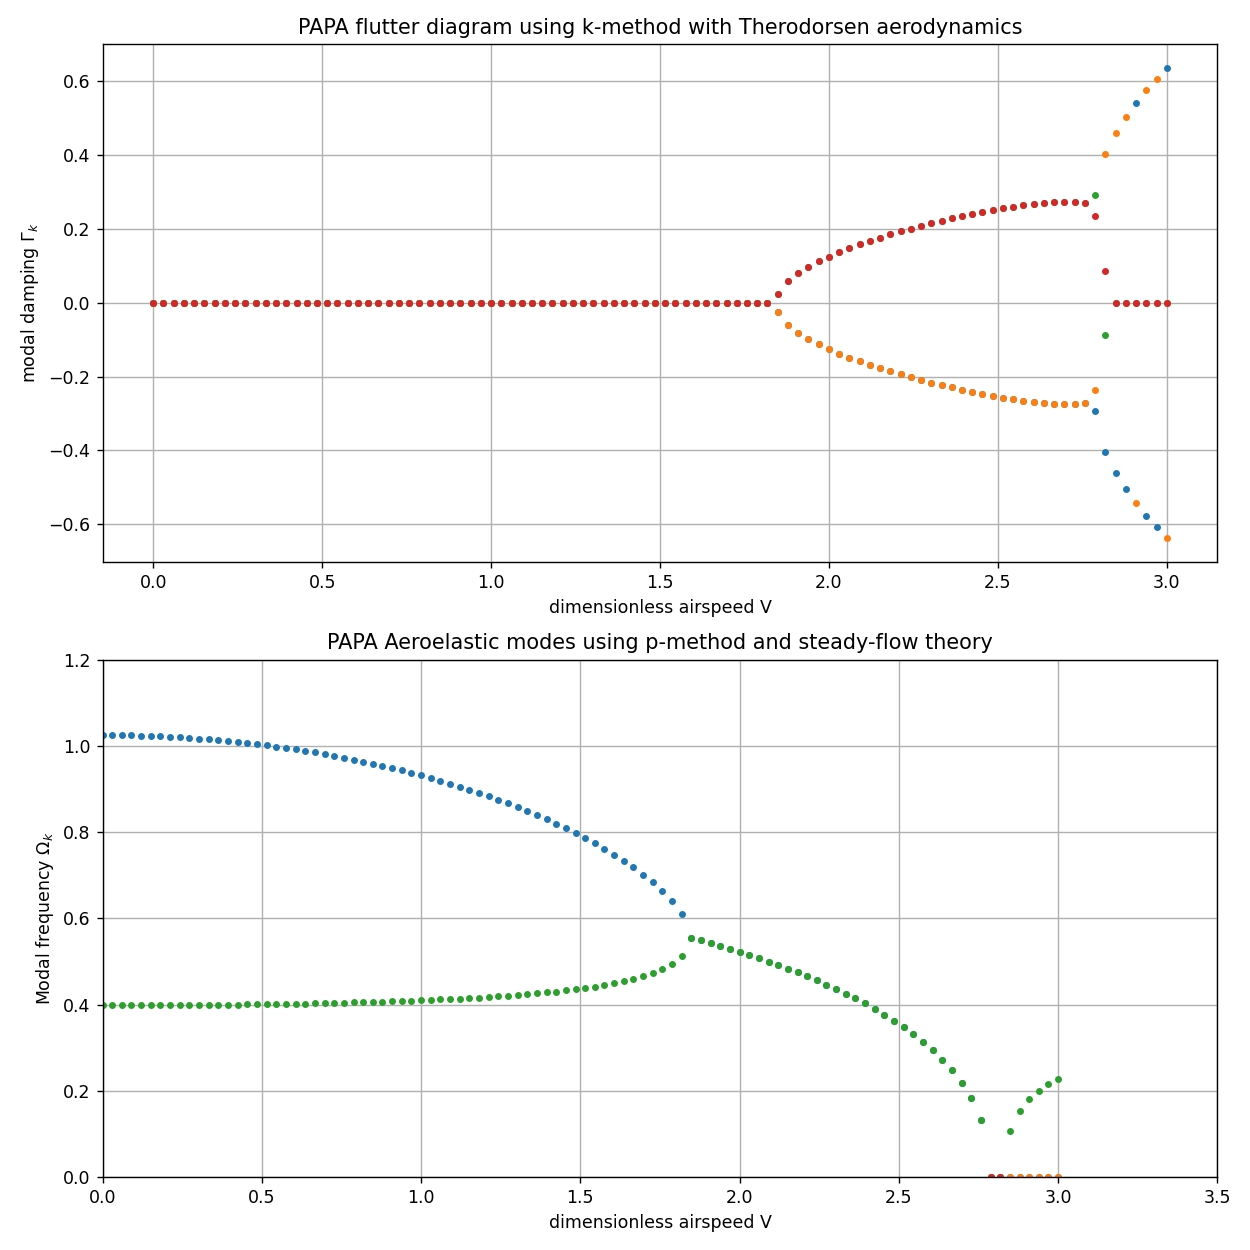

In [12]:
fig1=plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)

plt.plot(speed_index, dmpg[0,:], '.')
plt.plot(speed_index, dmpg[1,:], '.')
plt.plot(speed_index, dmpg[2,:], '.')
plt.plot(speed_index, dmpg[3,:], '.')

plt.title('PAPA flutter diagram using k-method with Therodorsen aerodynamics')
plt.xlabel('dimensionless airspeed V')
plt.ylabel('modal damping $\Gamma_k$')

plt.grid(True)

# -------------------------------------

plt.subplot(2, 1, 2)

plt.plot(speed_index, frq[0,:], '.')
plt.plot(speed_index, frq[1,:], '.')
plt.plot(speed_index, frq[2,:], '.')
plt.plot(speed_index, frq[3,:], '.')

plt.title('PAPA Aeroelastic modes using p-method and steady-flow theory')
plt.xlabel('dimensionless airspeed V')
plt.ylabel('Modal frequency $\Omega_k$')

plt.grid(True)
plt.axis([0, 3.5, 0, 1.2])   

plt.tight_layout()
plt.show()

# fig1.savefig('./figures/PAPA_p_method_fig1.png')
# fig1.savefig('./figures/PAPA_p_method_fig1.eps')
# fig1.savefig('./figures/PAPA_p_method_fig1.pdf')

We observe 3 set of colors. Depending on the speed, we may have 1, or two solutions.

For second graph :
* we have at zero speed, a frequency around 1 which is the torsion mode (couple with some flexion due to static disequilibrium).
* the frequency at 0.4 corresponds to the frequency omg_za

For first graph, it represents damping coeff, symmetrical with respect to x axis :
* when $|a| > 0 \rightarrow$ unstable. Then critic flutter speed $V_D$ is the speed at which $a \neq 0$.

Overall, we have 4 modes apparently, some in torsion and some in flexion, depending on the speed.

These frequencies are not resonance point as we recall it. Its aero flutter that takes into account the influence of the flow on modes.

These results are not physical given in real case, *a* isn't null for $V < V_D$. It's due to the fact we neglected $M_A$, which creates major error.
This term $M_A$ presents aero damping.

**Questions #3:**

$\quad$  3.1) Why classical flutter is also called **coalescence** flutter or flutter **merging** or **binary** flutter ? 

$\quad$  3.2) Which phenomenom is observed for $V=2.75$.

$\quad$  3.3) Code a function to compute $V_D$.

$\quad$  3.4) What means zero aeromechanical damping in term of observed aeroelastic response ?

$\quad$  3.5) Is it realistic to observe zero aeromechanical damping from $V=0$ up to $V_f$ ? 

$\quad$  3.6) According to Class Note 1 and the definition of flutter as a dynamic instability, which assumption is not adequate is the present approach ?

$\quad$  3.7) Plot 1D and 2D response surfaces of $V_f$ according to a 15 percent variation in the  aeromechanical parameters. Draw some conclusions about their influence on $V_f$ and identify the optimal configuration. 

---------------------------------------------------

**Reference**

[1] D.H. Hodges, G. A. Pierce, "Introduction to Structural Dynamics and Aeroelasticity ", Cambridge Aerospace series, 
ISBN 0-521-80698-4, 2002 ( Fig. 4.3 p. 123)

-----------------------------------------------------------------------------

_End of this notebook_

